In [1]:
# slices = {
#     'u': [0, :max_col, ...]
# }

In [35]:
import h5py
import netCDF4
import numpy as np
import os.path as osp

ecmwf_filenames = [
    'ECMWF_20060101_00',
    'ECMWF_20060101_06',
    'ECMWF_20060101_12',
    'ECMWF_20060101_18',
    'ECMWF_20060102_00',
    'ECMWF_20060102_06',
    'ECMWF_20060102_12',
    'ECMWF_20060102_18',
]

data_path = osp.join('/', 'root', 'model-collection', 'wmed', 'data')
raw_data_path = osp.join(data_path, 'raw')
processed_data_path = osp.join(data_path, 'processed')

max_col = 15
# [1, :max_col, ...]
for idx, fn in enumerate(ecmwf_filenames):
    with netCDF4.Dataset(osp.join(raw_data_path, f'{fn}.nc')) as infile:
        feats = {
            'u': infile['UT'][0, :max_col, ...].data,
            'v': infile['VT'][0, :max_col, ...].data,
            'sst': infile['SST'][:].data,
            'p': infile['PABST'][0, :max_col, ...].data,
            'levels': infile['ZHAT'][:].data,
            'humidity': infile['RVT'][0, :max_col, ...].data,
            'theta': infile['THT'][0, :max_col, ...].data,
        }
        
        if idx == 0:
            static = {
                'era5_lon': infile['LON'][:].data,
                'era5_lat': infile['LAT'][:].data,
                'era5_mask': np.array(infile['SSS'][:].data != 999),
            }
            with h5py.File(osp.join(processed_data_path, f'static.h5'), 'a') as file:
                for var, data in static.items():
                    if var in file.keys():
                        del file[var]
                    file.create_dataset(var, data=data)
        
    with h5py.File(osp.join(processed_data_path, f'ecmwf_{idx}.h5'), 'w') as outfile:
        for var, data in feats.items():
            outfile.create_dataset(var, data=data)

In [34]:
with h5py.File(osp.join(processed_data_path, f'static.h5'), 'r') as file:
    print(type(file['/era5_mask'][:]))

<class 'numpy.ndarray'>


In [89]:
croco_filenames = [
    'croco_his'
]

with netCDF4.Dataset(osp.join(raw_data_path, f'{croco_filenames[0]}.nc')) as infile:
    
    feats = {
        'u': infile['u'][1:, -1, ...].data,
        'v': infile['v'][1:, -1, ...].data,
        't': infile['temp'][1:, -1, ...].data,
        'tau_x': infile['sustr'][1:, ...].data,
        'tau_y': infile['svstr'][1:, ...].data,
        'q': infile['shflux'][1:, ...].data,
    }
    static = {
        'croco_lon_u': infile['lon_u'][:].data,
        'croco_lat_u': infile['lat_u'][:].data,
        'croco_lon_v': infile['lon_v'][:].data,
        'croco_lat_v': infile['lat_v'][:].data,
        'croco_lon_rho': infile['lon_rho'][:].data,
        'croco_lat_rho': infile['lat_rho'][:].data,
        'croco_mask': infile['mask_rho'][:].data,
    }

for instant in np.arange(feats['u'].shape[0]):
    with h5py.File(osp.join(processed_data_path, f'croco_{instant + 1}.h5'), 'w') as outfile:
        for var, data in feats.items():
            print(data[instant, ...].shape)
            outfile.create_dataset(var, data=data[instant, ...])

with h5py.File(osp.join(processed_data_path, f'static.h5'), 'a') as file:
    for var, data in static.items():
        if var in file.keys():
            del file[var]
        file.create_dataset(var, data=data)

(539, 630)
(538, 631)
(539, 631)
(539, 630)
(538, 631)
(539, 631)
(539, 630)
(538, 631)
(539, 631)
(539, 630)
(538, 631)
(539, 631)
(539, 630)
(538, 631)
(539, 631)
(539, 630)
(538, 631)
(539, 631)


In [90]:
type(feats['u'].data)

memoryview

In [91]:
import numpy as np
a = np.array([1,3,5])
b = np.array([2,4,6])

c = np.empty((a.size + b.size,), dtype=a.dtype)
c[0::2] = a
c[1::2] = b
c

array([1, 2, 3, 4, 5, 6])

In [92]:
feats['v'].shape

(3, 538, 631)

In [97]:
print(u.shape, v.shape, t.shape)

(539, 630) (538, 631) (539, 631)


In [127]:
with h5py.File(osp.join(processed_data_path, f'croco_1.h5'), 'a') as file:
    
    u = file['/u'][:]
    v = file['/v'][:]
    t = file['/t'][:]
    
    feats_map = np.zeros((2 * v.shape[0] + 1, 2 * u.shape[1] + 1), dtype=t.dtype)
    print(feats_map.shape)
    feats_map[0::2, 0::2] = t
    feats_map[1::2, 0::2] = v
    feats_map[0::2, 1::2] = u

(1077, 1261)


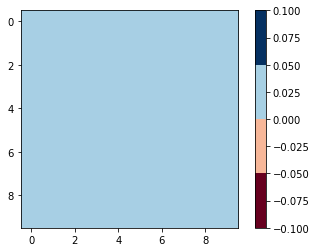

In [129]:
import matplotlib.pyplot as plt
plt.imshow(feats_map[0:10, 0:10], cmap=plt.get_cmap('RdBu', 4))
plt.colorbar()

In [56]:
feats_map.shape

(1078, 1261)

In [60]:
v.shape[0] * 2

1078

In [12]:
with h5py.File(osp.join(processed_data_path, f'static.h5'), 'r') as file:
    print(file.keys())

<KeysViewHDF5 ['croco_lat_rho', 'croco_lat_u', 'croco_lat_v', 'croco_lon_rho', 'croco_lon_u', 'croco_lon_v', 'era5_lat', 'era5_lon']>


In [ ]:
import numpy as np

def buil_feats(
    i: int,
    j: int,
    radius: int = 1) -> np.ndarray:
    
    feats = np.hstack(
        sst(i, j),
        u(i, j),
        v(i, j),
        atm_fields(i, j)
    )
    
    return feats
    
def sst(i, j, radius):
    """Oceanic temperature field T (K)"""
    return extract_feats(i, j, 0, 0, radius)

def u(i, j, radius):
    """Oceanic current speed field u (m.s-1)"""
    return extract_feats(i, j, 0, 1, radius)
    
def v(i, j, radius):
    """Oceanic current speed field v (m.s-1)"""
    return extract_feats(i, j, 1, 0, radius)
    
def atm_fields(i, j):
    """Atmospheric fields phi (K), U (m.s-1), and V (m.s-1)"""
    overgrid_resolution = era5_matrix.shape
    return extract_feats(i, j, 1, 0, 0)

def extract_feats(i, j, offset_i, offset_j):
    pass
    
# def phi(i, j, radius):
#     """Atmospheric temperature field T (K)"""
#     return extract_feats(i, j, -1, 0)
    
# def U(i, j, radius):
#     """Atmospheric wind speed field U (m.s-1)"""
#     return extract_feats(i, j, -1, 0)
    
# def V(i, j, radius):
#     """Atmospheric temperature field V (m.s-1)"""
#     return extract_feats(i, j, -1, 0)

In [ ]:
def extract_feats(i, j, offset_i, offset_j):
    

In [2]:
import h5py
import os
import netCDF4


with netCDF4.Dataset(os.path.join('/', 'root', 'model-collection', 'wmed', 'data', 'raw', 'croco_his.nc'), 'r') as file:
    print(file.variables.keys())
    u = file['u'][:, -1, ...]
    v = file['v'][:, -1, ...]
    sst = file['temp'][:, -1, ...]
    mask = file['mask_rho'][:]

dict_keys(['spherical', 'xl', 'el', 'xi_rho', 'xi_u', 'eta_rho', 'eta_v', 'Vtransform', 's_rho', 's_w', 'sc_r', 'sc_w', 'Cs_r', 'Cs_w', 'hc', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'angle', 'mask_rho', 'time_step', 'scrum_time', 'time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt', 'w', 'bostr', 'wstr', 'sustr', 'svstr', 'AKt', 'hbl', 'hbbl', 'shflux', 'swflux', 'swrad'])


(4, 539, 630)
(4, 538, 631)
(4, 539, 631)


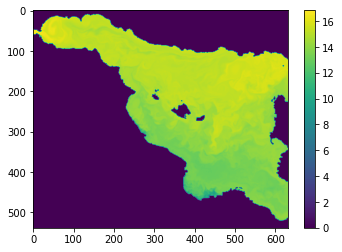

In [8]:
import matplotlib.pyplot as plt

print(u.shape)
print(v.shape)
print(sst.shape)
plt.imshow(sst[1])
plt.colorbar()

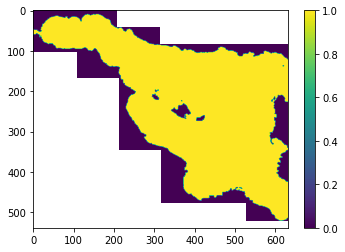

In [9]:

plt.imshow(mask)
plt.colorbar()

In [7]:
mask

masked_array(
  data=[[0.0, 0.0, 0.0, ..., --, --, --],
        [0.0, 0.0, 0.0, ..., --, --, --],
        [0.0, 0.0, 0.0, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=9.96921e+36,
  dtype=float32)

In [23]:
u

masked_array(
  data=[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [24]:
u[1].mask = mask

In [18]:
u.mask

array([[[False, False, False, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [25]:
u.shape

(4, 539, 630)

In [27]:
u[1].mask

False

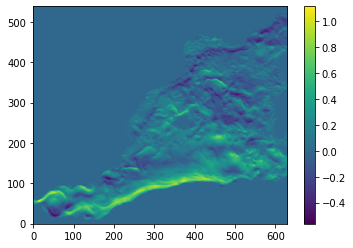

In [26]:
plt.imshow(u[1], origin='lower')
plt.colorbar()

In [11]:
type(mask)

numpy.ma.core.MaskedArray

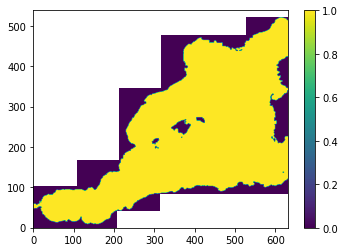

In [15]:
plt.imshow(mask, origin='lower')
plt.colorbar()

In [27]:
with h5py.File(os.path.join('/', 'root', 'model-collection', 'wmed', 'data', 'raw', 'WMED0.1.SEG01.001.nc'), 'r') as file:
    # print(file.keys())
    sst = file['SST'][:]

In [28]:
sst.shape

(110, 130)

In [4]:
import h5py
import os
from pprint import pprint

with h5py.File(os.path.join('/', 'root', 'model-collection', 'wmed', 'data', 'raw', 'ECMWF_20060101_00.nc'), 'r') as file:
    pprint(file.keys())
    sst_ecmwf = file['SST'][:]
    tht_ecmwf = file['THT'][0, 0, ...]

<KeysViewHDF5 ['ASN_VEGP1', 'AVG_ZS', 'BETA', 'BIBUSER', 'BUDC', 'BUG', 'BUGFIX', 'CARTESIAN', 'COUPLING', 'CPL_AROME', 'DAD_NAME', 'DIM_FULL', 'DRYMASST', 'DTCUR', 'DTEXP', 'DTMOD', 'DTSEG', 'DUMMY_GR_NBR', 'EXNTOP', 'FILETYPE', 'FREE_ATM_GR', 'GLACIER', 'GRID_TYPE', 'HANDLE_SIC', 'HORELAX_R', 'HORELAX_UVWTH', 'HS', 'IMAX', 'ISBA_CANOPY', 'JMAX', 'JPHEXT', 'KMAX', 'L1D', 'L2D', 'LAT', 'LAT0', 'LATOR', 'LATORI', 'LBOUSS', 'LBXRVM', 'LBXTHM', 'LBXUM', 'LBXVM', 'LBXWM', 'LBYRVM', 'LBYTHM', 'LBYUM', 'LBYVM', 'LBYWM', 'LCOUPLES', 'LCPL_GCM', 'LOCEAN', 'LON', 'LON0', 'LONOR', 'LONORI', 'LSNOW_FRAC_T', 'LSRVM', 'LSTHM', 'LSUM', 'LSVM', 'LSWM', 'MASDEV', 'MAX_ZS', 'MIN_ZS', 'MNHVERSION', 'MY_NAME', 'NLITTER', 'NLITTLEVS', 'NSOILCARB', 'PABST', 'PACK', 'PATCHP1', 'PROGRAM', 'RECYCLING', 'RESAP1', 'RESPSL', 'RHOREFZ', 'RIMX', 'RIMY', 'RPK', 'RSN_VEG1P1', 'RVT', 'SEA_OCEAN', 'SEA_SBL', 'SIL_ZS', 'SLEVE', 'SN_VEGP1', 'SN_VEG_N', 'SN_VEG_TYP', 'SPLIT_PATCH', 'SSO_ANIS', 'SSO_DIR', 'SSO_SLOPE', 'SS

In [48]:
sst_ecmwf.shape

(110, 130)

In [49]:
tht_ecmwf.shape

(110, 130)

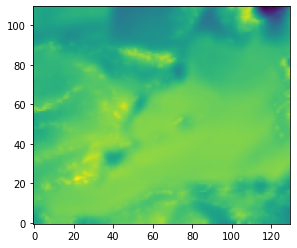

In [50]:

plt.imshow(tht_ecmwf, origin='lower')